In [1]:
import os
import mne
import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt # Keep original filtfilt for the improved func
# Removed resample as it wasn't used, can be added back if needed
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis
# Removed pywt as it wasn't used, can be added back if needed

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

# Suppress specific MNE warnings if desired, adjust as needed
warnings.filterwarnings("ignore", message=".*pick_types.*legacy function.*")
warnings.filterwarnings("ignore", message=".*maximum epoch persistence is not supported.*") # Common non-critical warning
mne.set_log_level('WARNING') # Reduce MNE verbosity

In [5]:
data_parents_path = '/kaggle/input/eeg-brain/Neural-Science/data'
label_path = os.path.join(data_parents_path, 'filtered_subjects_with_age.tsv') # Use os.path.join

label_df = pd.read_csv(label_path, sep='\\t')
# Ensure column names are correct (they might have spaces if copied/pasted)
label_df.columns = [col.strip() for col in label_df.columns]


/tmp/ipykernel_31/1993794607.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  label_df = pd.read_csv(label_path, sep='\\t')


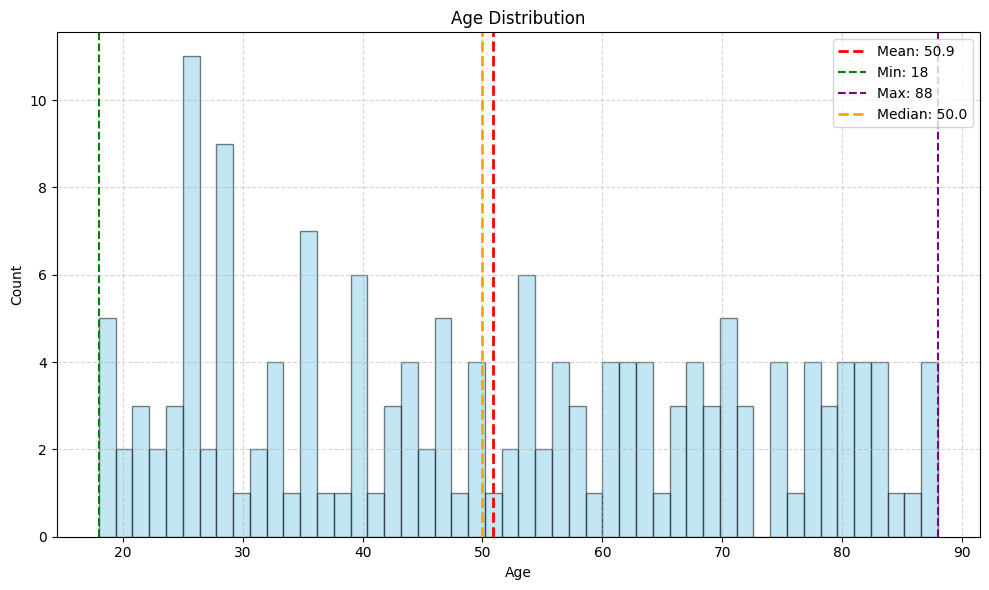

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Example DataFrame (replace this with your actual df)
# df = pd.read_csv("your_file.csv")  # If loading from file
# For demonstration, generating random age data:
import numpy as np
# Plot
plt.figure(figsize=(10, 6))
plt.hist(label_df['age'], bins=50, color='skyblue', edgecolor='black', alpha=0.5)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

# Calculate statistics
mean_age = label_df['age'].mean()
min_age = label_df['age'].min()
max_age = label_df['age'].max()
median_age = label_df['age'].median()

# Add vertical lines and labels for stats
plt.axvline(mean_age, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_age:.1f}')
plt.axvline(min_age, color='green', linestyle='--', linewidth=1.5, label=f'Min: {min_age}')
plt.axvline(max_age, color='purple', linestyle='--', linewidth=1.5, label=f'Max: {max_age}')
plt.axvline(median_age, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_age}')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [24]:
import mne
# Define the path to the file
file_path = "/kaggle/input/eeg-brain/Neural-Science/data/group_1/sub-CC110033_sflip_parc-raw.fif"
# Load the raw data
raw = mne.io.read_raw_fif(file_path, preload=True)
# Display information about the raw object
print(raw.info)

<Info | 11 non-empty values
 bads: []
 ch_names: parcel_0, parcel_1, parcel_2, parcel_3, parcel_4, parcel_5, ...
 chs: 52 misc, 17 Stimulus
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition OSL ...
 dig: 0 items
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 1916-01-09 10:21:05 UTC
 meas_id: 4 items (dict)
 nchan: 69
 projs: []
 sfreq: 250.0 Hz
>


In [25]:
# Extract only MISC channels
misc_channels = raw.copy().pick_types(misc=True)
# Display information about the extracted channels
print(misc_channels.info)

<Info | 11 non-empty values
 bads: []
 ch_names: parcel_0, parcel_1, parcel_2, parcel_3, parcel_4, parcel_5, ...
 chs: 52 misc
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition OSL ...
 dig: 0 items
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 1916-01-09 10:21:05 UTC
 meas_id: 4 items (dict)
 nchan: 52
 projs: []
 sfreq: 250.0 Hz
>


In [26]:
# Get the total recording time in seconds
total_duration = raw.times[-1]
# Alternatively, using the raw.info dictionary
total_duration_alt = raw.n_times / raw.info['sfreq']
# Print the total duration
print(f"Total recording time: {total_duration:.2f} seconds")

Total recording time: 574.00 seconds
